In [97]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors

## set up example

In [98]:
thrust = torch.tensor([0., 0., 0., 0.99, 0.99,
          0.97373036, 0.92826162, 0.89210543, 0.86100905, 0.835423,
          0.81237673, 0.79225789, 0.77584769, 0.7629228, 0.76156073,
          0.76261984, 0.76169723, 0.75232027, 0.74026851, 0.72987175,
          0.70701647, 0.54054532, 0.45509459, 0.39343381, 0.34250785,
          0.30487242, 0.27164979, 0.24361964, 0.21973831, 0.19918151,
          0.18131868, 0.16537679, 0.15103727, 0.13998636, 0.1289037,
          0.11970413, 0.11087113, 0.10339901, 0.09617888, 0.09009926,
          0.08395078, 0.0791188, 0.07448356, 0.07050731, 0.06684119,
          0.06345518, 0.06032267, 0.05741999, 0.05472609, 0.,
          0.])

wind_speed = torch.tensor([0.,  2.,  2.5,  3.,  3.5,  4.,  4.5,  5.,  5.5,
              6.,  6.5,  7.,  7.5,  8.,  8.5,  9.,  9.5, 10.,
              10.5, 11., 11.5, 12., 12.5, 13., 13.5, 14., 14.5,
              15., 15.5, 16., 16.5, 17., 17.5, 18., 18.5, 19.,
              19.5, 20., 20.5, 21., 21.5, 22., 22.5, 23., 23.5,
              24., 24.5, 25., 25.01, 25.02, 50.])

power = torch.tensor([0., 0., 0., 0.178085, 0.289075, 0.349022,
         0.384728, 0.406059, 0.420228, 0.428823, 0.433873, 0.436223,
         0.436845, 0.436575, 0.436511, 0.436561, 0.436517, 0.435903,
         0.434673, 0.43323, 0.430466, 0.378869, 0.335199, 0.297991,
         0.266092, 0.238588, 0.214748, 0.193981, 0.175808, 0.159835,
         0.145741, 0.133256, 0.122157, 0.112257, 0.103399, 0.095449,
         0.088294, 0.081836, 0.075993, 0.070692, 0.065875, 0.061484,
         0.057476, 0.053809, 0.050447, 0.047358, 0.044518, 0.0419,
         0.039483, 0., 0.])

air_density = 1.225 # same as `examples/inputs/gch.yaml`

generator_efficiency = 1.0
turbine_hub_height = 90.0
pP = 1.88
turbine_diameter = 126.0
TSR = 8.0

rloc = 0.5
turbine_radius = turbine_diameter / 2.0

# 6x6
# x_coord = torch.tensor([0.]*6 + [6.]*6 + [12.]*6 + [18.]*6 + [24.]*6 + [30.]*6) * turbine_diameter
# y_coord = torch.tensor([0., 3., 6., 9., 12., 15.]*6) * turbine_diameter

#4x4
# x_coord = torch.tensor([0., 0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 
#                         12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter,
#                         18.*turbine_diameter, 18.*turbine_diameter, 18.*turbine_diameter, 18.*turbine_diameter])

# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter])

#3x3
x_coord = torch.tensor([0., 6.*turbine_diameter, 12.*turbine_diameter,
                        0., 6.*turbine_diameter, 12.*turbine_diameter,
                        0., 6.*turbine_diameter, 12.*turbine_diameter])
            
y_coord = torch.tensor([6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
                        3.*turbine_diameter, 3.*turbine_diameter, 3.*turbine_diameter,
                        0., 0., 0., ])

#3x1, 2x1, 1x1
# x_coord = torch.tensor([0., 0., 0., 
#                         6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter,
#                         0.])

#3x1, 2x1
# x_coord = torch.tensor([0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter,
#                         0., 3.*turbine_diameter,
#                         0.])

# 3x1, 3x1, 1x1, symmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         3.*turbine_diameter,])

# 3x1, 3x1, 1x1, asymmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0.])

# 4x1, 4x1, 2x1, asymmetric
# x_coord = torch.tensor([0., 0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter])

# 3x1, 1x1, 1x1, symmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         3.*turbine_diameter,
#                         3.*turbine_diameter,])

# 3x1, 1x1, 1x1, asymmetric
# x_coord = torch.tensor([0., 0., 0., 
#                         6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0.,
#                         0.])

# 1x1, 1x1, 3x1, asymmetric
# x_coord = torch.tensor([0.*turbine_diameter,
#                         6.*turbine_diameter,
#                         12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([6.*turbine_diameter,
#                         6.*turbine_diameter,
#                         6.*turbine_diameter, 3.*turbine_diameter, 0.])

# 2x2
# x_coord = torch.tensor([0., 0., 6.*turbine_diameter, 6.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 0., 3.*turbine_diameter])

# 2x2 uniform spacing in x&y directions
# x_coord = torch.tensor([0., 0., 6.*turbine_diameter, 6.*turbine_diameter])
# y_coord = torch.tensor([0., 6.*turbine_diameter, 0., 6.*turbine_diameter])

# 2x1, 1x1
# x_coord = torch.tensor([0., 0., 6.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 3.*turbine_diameter])

# 1x1, 1x1, 1x1
# x_coord = torch.tensor([0., 6.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([0., 0., 0.])

# 1x1, 1x1
# x_coord = torch.tensor([0., 6.*turbine_diameter])
# y_coord = torch.tensor([0., 0.*turbine_diameter])

nturbs = len(x_coord)
z_coord = torch.tensor([90.0] * nturbs)

y_ngrid = 3
z_ngrid = 3

# Wind parameters
ws_max = 8.0
wd_fixed = 275.
wd_max = 360.

specified_wind_height = 90.0
wind_shear = 0.12
wind_veer = 0.0
TI = 0.06

# yaw parameters
umin = torch.tensor([0]) # min allowed yaw angle (degrees)
umax = torch.tensor([25.]) # max allowed yaw angle (degrees)

# dropout parameters
dropout=True
active_prob = .5 # probability turbine is active during training

# neural net parameters
model_config = dict({"n_turbines": nturbs, "hidden_dim": 128, "dropout": dropout})

# hyperparameters -> selected ad hoc; should do hyperparameter training
# u_penalty = 10.
lr = .00025
batch_size = 50
num_batches = 400

## Functions

In [99]:
def cosd(angle):
    return torch.cos(torch.deg2rad(angle))

def sind(angle):
    return torch.sin(torch.deg2rad(angle))

def tand(angle):
    return torch.tan(torch.deg2rad(angle))

def interp(x, y, x_new):
    x_new_indices = torch.searchsorted(x, x_new)
    x_new_indices = x_new_indices.clip(1,len(x)-1)
    lo = x_new_indices - 1
    hi = x_new_indices
    x_lo = x[lo]
    x_hi = x[hi]
    y_lo = y[lo]
    y_hi = y[hi]
    slope = (y_hi - y_lo) / (x_hi - x_lo)
    return slope*(x_new - x_lo) + y_lo

def gaussian_function(U, C, r, n, sigma):
    return C * torch.exp(-1 * r ** n / (2 * sigma ** 2))

In [100]:
class DPCModel(nn.Module):
    def __init__(
        self,
        n_turbines: int,
        hidden_dim: int = 64,
        dropout: bool = False,
        **kwargs
    ):
        super().__init__()
        input_size = 2 # ws, wd
        if dropout:
            input_size += n_turbines # dropout (T/F for each turbine)
        self.input_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layer1 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer3 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer4 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer5 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer6 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, n_turbines)
        
    def forward(self, x):
        # x: state of system = torch.tensor([ws, wd])
        # u: control action (yaw angle for each turbine)
        u = F.relu(self.input_layer(x))
        u = F.relu(self.hidden_layer1(u))
#         u = F.relu(self.hidden_layer2(u))
#         u = F.relu(self.hidden_layer3(u))
#         u = F.relu(self.hidden_layer4(u))
#         u = F.relu(self.hidden_layer5(u))
#         u = F.relu(self.hidden_layer6(u))
        u = torch.sigmoid(self.output_layer(u))*1.2 - .1 # shift to allow exploration beyond constraints
        return u

In [101]:
def get_control(ws, wd, inds_sorted, active_turbs=torch.tensor([False]*nturbs)):
    ## get control action ##
    # normalize features to range [0,1] by dividing ws by ws_max and wd by wd_max
    # dropout already 0 or 1
#     x = torch.cat([ws/ws_max, wd/wd_max, active_turbs])
#     x = torch.cat([ws/ws_max, (wd-270.)/90., active_turbs])
#     x = torch.cat([ws/ws_max, (wd-270.)/89., active_turbs])
#     x = torch.cat([ws/ws_max, wd/359., active_turbs])

    x = torch.cat([ws/ws_max, wd/wd_max, active_turbs])
    u = model(x)
    clipped_u = F.relu(u*umax-umin) + umin
    clipped_u = -F.relu(-clipped_u + umax) + umax
#     clipped_u = torch.clone(u)*umax
    if active_turbs is not None:
        clipped_u = clipped_u[active_turbs]
    clipped_u_sorted = clipped_u[inds_sorted.flatten()]
    return clipped_u_sorted, clipped_u, u

In [102]:
def get_turbine_mesh(wd, x_coord_full, y_coord_full, z_coord_full, active_turbs=None):
    # apply dropout
    if active_turbs is not None:
        x_coord = x_coord_full[active_turbs]
        y_coord = y_coord_full[active_turbs]
        z_coord = z_coord_full[active_turbs]
        
    x_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    y_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    z_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))

    angle = ((wd - 270) % 360 + 360) % 360

    x1, x2, x3 = x_coord, y_coord, z_coord

    pt = rloc * turbine_radius

    # linspace for an array; torch.linspace only takes scalar
    steps = torch.arange(y_ngrid).unsqueeze(-1) / (y_ngrid - 1)
    yt = (x2 - pt) + steps*2.*pt

    steps = torch.arange(z_ngrid).unsqueeze(-1) / (z_ngrid - 1)
    zt = (x3 - pt) + steps*2.*pt

    x_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * x_coord[:, None, None]
    y_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * yt.T[:, :, None]
    z_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * zt.T[:, None, :]

    # yaw turbines to be perpendicular to the wind direction
    wind_direction_i = angle[None, :, None, None, None, None]
    xoffset = x_grid - x1[:, None, None]
    yoffset = y_grid - x2[:, None, None]
    wind_cos = cosd(-wind_direction_i)
    wind_sin = sind(-wind_direction_i)
    x_grid = xoffset * wind_cos - yoffset * wind_sin + x1[:, None, None]
    y_grid = yoffset * wind_cos + xoffset * wind_sin + x2[:, None, None]

    mesh_x = x_grid
    mesh_y = y_grid
    mesh_z = z_grid

    # rotate turbine locations/fields to be perpendicular to wind direction
    x_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_x), torch.max(mesh_x)]))
    y_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_y), torch.max(mesh_y)]))
    angle = ((wd[None, :, None, None, None, None] - 270) % 360 + 360) % 360
    x_offset = mesh_x - x_center_of_rotation
    y_offset = mesh_y - y_center_of_rotation
    mesh_x_rotated = (x_offset * cosd(angle) - y_offset * sind(angle) 
                      + x_center_of_rotation)
    mesh_y_rotated = (x_offset * sind(angle) + y_offset * cosd(angle) 
                      + y_center_of_rotation)
    x_coord_offset = (x_coord - x_center_of_rotation)[:, None, None]
    y_coord_offset = (y_coord - y_center_of_rotation)[:, None, None]
    x_coord_rotated = (x_coord_offset * cosd(angle)
        - y_coord_offset * sind(angle)
        + x_center_of_rotation)
    y_coord_rotated = (x_coord_offset * sind(angle)
        + y_coord_offset * cosd(angle)
        + y_center_of_rotation)
    inds_sorted = x_coord_rotated.argsort(axis=3)

    x_coord_rotated = torch.gather(x_coord_rotated, 3, inds_sorted)
    y_coord_rotated = torch.gather(y_coord_rotated, 3, inds_sorted)
#     z_coord_rotated = torch.gather(z_coord * np.ones((np.shape(x_coord_rotated))), 
#                                    3, inds_sorted)
    
    mesh_x_rotated = torch.take_along_dim(mesh_x_rotated, inds_sorted, 3)
    mesh_y_rotated = torch.take_along_dim(mesh_y_rotated, inds_sorted, 3)
#     mesh_z_rotated = torch.take_along_dim(mesh_z * np.ones((np.shape(mesh_x_rotated))), 
#                                           inds_sorted, 3)
    #inds_unsorted = x_coord_rotated.argsort(axis=3)
    
    return x_coord_rotated, y_coord_rotated, \
        mesh_x_rotated, mesh_y_rotated, mesh_z, \
        inds_sorted, x_coord

In [103]:
def get_field_rotor(ws, wd, clipped_u, \
        x_coord_rotated, y_coord_rotated, 
        mesh_x_rotated, mesh_y_rotated, mesh_z, \
        inds_sorted, x_coord):   
    
    ## initialize flow field ##
    
    flow_field_u_initial = (ws[None, None, :, None, None, None] 
                        * (mesh_z / specified_wind_height) ** wind_shear) \
                        * np.ones((1, len(wd), 1, 1, 1, 1))

    ## initialize other field values ##
    u_wake = torch.zeros(np.shape(flow_field_u_initial))
    flow_field_u = flow_field_u_initial - u_wake
    turb_inflow_field = torch.ones(np.shape(flow_field_u_initial)) * flow_field_u_initial

    ## Initialize turbine values ##
    turb_TIs = torch.ones_like(x_coord_rotated) * TI
    ambient_TIs = torch.ones_like(x_coord_rotated) * TI
    yaw_angle = clipped_u.reshape(x_coord_rotated.shape)
    turbine_tilt = torch.ones_like(x_coord_rotated) * 0.0

    # Loop over turbines to solve wakes
    for i in range(len(x_coord)):
        turb_inflow_field = turb_inflow_field \
        * (mesh_x_rotated != x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]) \
        + (flow_field_u_initial - u_wake) \
        * (mesh_x_rotated == x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])

        turb_avg_vels = torch.pow(torch.mean(turb_inflow_field ** 3, dim=(4,5)), 1./3.)

        Ct = interp(wind_speed, thrust, turb_avg_vels)
        yaw_angle_flat = torch.squeeze(torch.squeeze(yaw_angle, dim=4), dim=4)
        Ct *= cosd(yaw_angle_flat) # effective thrust
        Ct = Ct * (Ct < 1.0) + 0.9999 * torch.ones_like(Ct) * (Ct >= 1.0)
        turb_Cts = Ct * (Ct > 0.0) + 0.0001 * torch.ones_like(Ct) * (Ct <= 0.0)

        turb_aIs = 0.5 / cosd(yaw_angle_flat) * (1 - torch.sqrt(1 - turb_Cts * cosd(yaw_angle_flat) + 1e-16))

        ## Wake deflection calculation ##
        yaw = yaw_angle # if no secondary steering    
        x_coord_rotated_i = x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        y_coord_rotated_i = y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_ti_i = turb_TIs[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_Ct_i = turb_Cts[:, :, :, i][:, :, :, None, None, None]
        yaw_i = yaw[:, :, :, i, :, :][:, :, :, None, :, :]
        neg_yaw_i = -1. * yaw_i # wake deflection has opposite sign convention
        
        ka = 0.38  # wake expansion parameter
        kb = 0.004  # wake expansion parameter
        alpha = 0.58  # near wake parameter
        beta = 0.077  # near wake parameter
        ad = 0.0  # natural lateral deflection parameter
        bd = 0.0  # natural lateral deflection parameter
        dm = 1.0

        U_local = flow_field_u_initial

        # initial velocity deficits
        uR = (U_local * turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)
              / (2.0 * (1 - torch.sqrt(1 - (turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)) + 1e-16))))
        u0 = U_local * torch.sqrt(1 - turbine_Ct_i + 1e-16)

        # length of near wake
        x0 = (turbine_diameter
              * (cosd(neg_yaw_i) * (1 + torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16)))
              / (np.sqrt(2) * (4 * alpha * turbine_ti_i + 2 * beta * (1 - torch.sqrt(1 - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # wake expansion parameters
        ky = ka * turbine_ti_i + kb
        kz = ka * turbine_ti_i + kb

        C0 = 1 - u0 / flow_field_u_initial
        M0 = C0 * (2 - C0)
        E0 = C0 ** 2 - 3 * np.exp(1.0 / 12.0) * C0 + 3 * np.exp(1.0 / 3.0)

        # initial Gaussian wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        yR = mesh_y_rotated - y_coord_rotated_i
        xR = x_coord_rotated_i

        # yaw_i parameter (skew angle)
        theta_c0 = (dm * (0.3 * torch.deg2rad(neg_yaw_i) / cosd(neg_yaw_i)) 
                    * (1 - torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16))) # skew angle in radians

        # yaw_i param (distance from centerline=initial wake deflection)
        # NOTE: use tan here since theta_c0 is radians
        delta0 = torch.tan(theta_c0) * (x0 - x_coord_rotated_i) 

        # deflection in the near wake
        delta_near_wake = ((mesh_x_rotated - xR) / (x0 - xR)) * delta0 \
            + (ad + bd * (mesh_x_rotated - x_coord_rotated_i))
        delta_near_wake = delta_near_wake * (mesh_x_rotated >= xR)
        delta_near_wake = delta_near_wake * (mesh_x_rotated <= x0)

        # deflection in the far wake
        sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
        sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
        sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
        sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

        ln_deltaNum = (1.6 + torch.sqrt(M0 + 1e-16)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) - torch.sqrt(M0 + 1e-16))
        ln_deltaDen = (1.6 - torch.sqrt(M0)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) + torch.sqrt(M0 + 1e-16))
        delta_far_wake = (delta0 + (theta_c0 * E0 / 5.2)
                          * torch.sqrt(sigma_y0 * sigma_z0 / (ky * kz * M0) + 1e-16)
                          * torch.log(ln_deltaNum / ln_deltaDen)
                          + (ad + bd * (mesh_x_rotated - x_coord_rotated_i)))
        delta_far_wake = delta_far_wake * (mesh_x_rotated > x0)
        deflection_field = delta_near_wake + delta_far_wake

        ## Calculate wake deficits ##
        # wake deflection
        delta = deflection_field

        # mask upstream wake
        xR = x_coord_rotated_i

        # mask upstream wake
        #   initial velocity deficits
        uR = U_local * turbine_Ct_i / (2.0 * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16)))
        u0 = U_local * torch.sqrt(1. - turbine_Ct_i + 1e-16)
        #   initial wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        # quantity that determines when the far wake starts
        x0 = (turbine_diameter * (cosd(neg_yaw_i) * (1. + torch.sqrt(1. - turbine_Ct_i + 1e-16)))
              / (np.sqrt(2.) * (4. * alpha * turbine_ti_i + 2. * beta 
                                   * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # velocity deficit in the near wake
        turb_u_wake = torch.zeros_like(U_local)
        near_wake_mask = (mesh_x_rotated > xR + 0.1) * (mesh_x_rotated < x0)
        if torch.sum(near_wake_mask):
            sigma_y = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_y0
            sigma_z = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_z0

            sigma_y = (sigma_y * (mesh_x_rotated >= xR) + torch.ones_like(sigma_y) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)
            sigma_z = (sigma_z * (mesh_x_rotated >= xR) + torch.ones_like(sigma_z) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)

            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * ((mesh_y_rotated - y_coord_rotated_i) - delta) ** 2
                 - 2 * b * ((mesh_y_rotated - y_coord_rotated_i) - delta) * ((mesh_z - turbine_hub_height))
                 + c * ((mesh_z - turbine_hub_height)) ** 2)

            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            turb_u_wake = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * near_wake_mask

        far_wake_mask = (mesh_x_rotated >= x0)
        if torch.sum(far_wake_mask):
            # wake expansion in the lateral (y) and the vertical (z)
            sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
            sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
            sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
            sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

            # velocity deficit outside the near wake
            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * (mesh_y_rotated - y_coord_rotated_i - delta) ** 2
                 - 2 * b * (mesh_y_rotated - y_coord_rotated_i - delta) * (mesh_z - turbine_hub_height)
                 + c * (mesh_z - turbine_hub_height) ** 2)
            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            # compute velocities in the far wake
            turb_u_wake1 = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * far_wake_mask
            turb_u_wake += turb_u_wake1

        ## Perform wake/field combinations ##
        u_wake = torch.sqrt((u_wake ** 2) + ((turb_u_wake * flow_field_u_initial) ** 2) + 1e-16)
        flow_field_u = flow_field_u_initial - u_wake

        ## Calculate wake overlap for wake-added turbulence (WAT) ##
        area_overlap = torch.sum(turb_u_wake * flow_field_u_initial > 0.05, axis=(4, 5)) / (y_ngrid * z_ngrid)

        ## Calculate WAT for turbines ##
        # turbulence intensity calculation based on Crespo et. al.
        turbine_aI_i = turb_aIs[:, :, :, i][:, :, :, None, None, None]
        ti_initial = 0.1
        ti_constant = 0.5
        ti_ai = 0.8
        ti_downstream = -0.32

        # replace zeros and negatives with 1 to prevent nans/infs
        # keep downstream components; set upstream to 1.0
        delta_x = mesh_x_rotated - x_coord_rotated_i
        upstream_mask = (delta_x <= 0.1)
        downstream_mask = (delta_x > -0.1)
        delta_x = delta_x * downstream_mask + torch.ones_like(delta_x) * upstream_mask
        ti_calculation = (ti_constant * turbine_aI_i ** ti_ai * ambient_TIs ** ti_initial \
                          * (delta_x / turbine_diameter) ** ti_downstream)

        # mask the 1 values from above w/ zeros
        WAT_TIs = ti_calculation * downstream_mask

        ## Modify WAT by wake area overlap ##
        # TODO: will need to make the rotor_diameter part of this mask work for
        # turbines of different types
        downstream_influence_length = 15 * turbine_diameter
        ti_added = (area_overlap[:, :, :, :, None, None] * torch.nan_to_num(WAT_TIs, posinf=0.0) 
            * (x_coord_rotated > x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])
            * (torch.abs(y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :] - y_coord_rotated) 
               < 2 * turbine_diameter)
            * (x_coord_rotated <= downstream_influence_length
               + x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]))

        ## Combine turbine TIs with WAT
        turb_TIs = torch.maximum(torch.sqrt(ti_added ** 2 + ambient_TIs ** 2 + 1e-16), turb_TIs,)    
        
    return flow_field_u, yaw_angle

In [104]:
def get_power(flow_field_u, x_coord_rotated, yaw_angle):
    ## power calculation (based on main floris branch) ##
    # omitted fCp_interp b/c interp power from wind_speed to wind_speed so does nothing...
    rotor_area = torch.pi * turbine_radius ** 2.0
    inner_power = 0.5*rotor_area*power*generator_efficiency*wind_speed**3

    # omiting some lines here b/c assuming all turbines have same type
    # ix_filter not implemented

    # Compute the yaw effective velocity
    pPs = torch.ones_like(x_coord_rotated) * 1.88 # `turbine_library/nrel_5MW.yaml`
    pW = pPs / 3.0  # Convert from pP to w
    axis = tuple([4 + i for i in range(flow_field_u.ndim - 4)])
    average_velocity = torch.pow(torch.mean(flow_field_u ** 3, axis=axis), 1./3.).reshape(yaw_angle.shape)
    yaw_effective_velocity = ((air_density/1.225)**(1/3)) * average_velocity * cosd(yaw_angle) ** pW

    # Power produced by a turbine adjusted for yaw and tilt. Value given in kW
    p = 1.225 * interp(wind_speed, inner_power, yaw_effective_velocity) / 1000.0

    return p

In [105]:
def test_power(ws_test, wd, test_powers, \
# def test_power(ws, wd_test, test_powers, \
    x_coord_full, y_coord_full, z_coord_full, active_turbs_test=None):
    
    for i in range(len(active_turbs_test)):
        active_turbs = active_turbs_test[i]
        test_power = 0.
        for ws in ws_test:
#         for wd in wd_test:
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
                get_turbine_mesh(wd, x_coord_full, y_coord_full, z_coord_full, active_turbs=active_turbs)
            clipped_u_sorted, clipped_u, u = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
            flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
                x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
            p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
            test_power += -torch.sum(p)
        test_power /= len(ws_test)
#         test_power /= len(wd_test)
        test_powers[i].append(test_power.detach().numpy())

## Training

batch: 10/400.


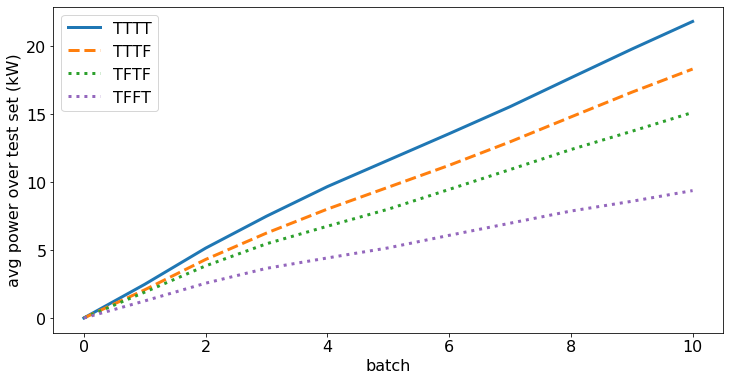

batch: 20/400.


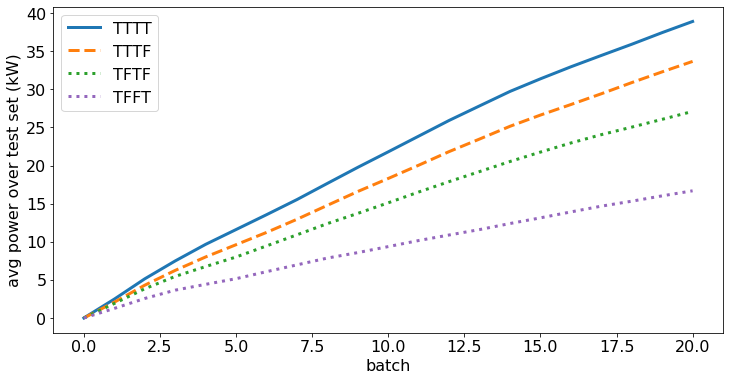

batch: 30/400.


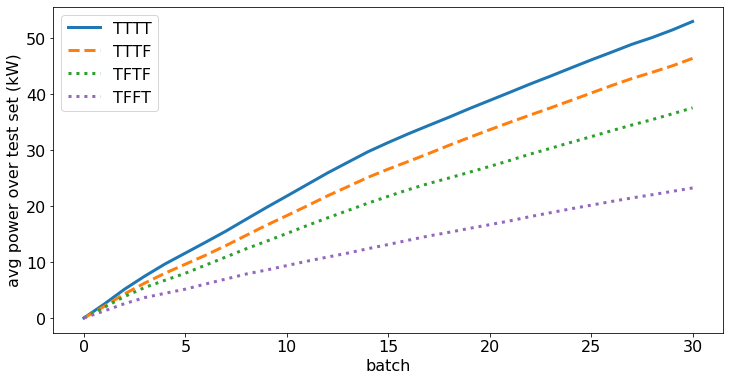

batch: 40/400.


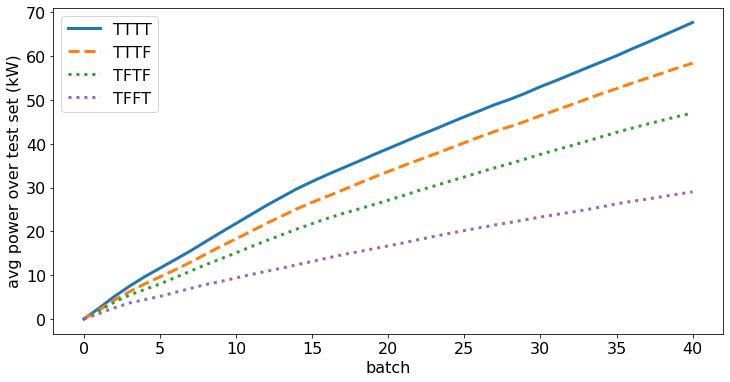

batch: 50/400.


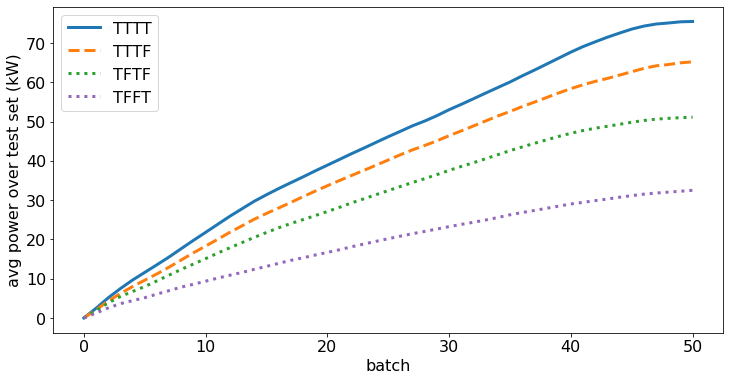

batch: 60/400.


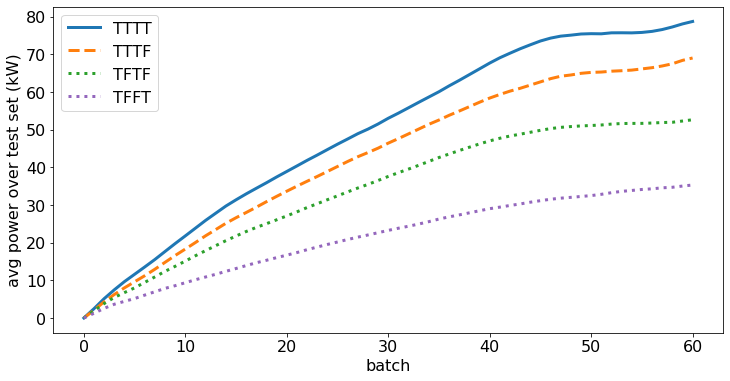

batch: 70/400.


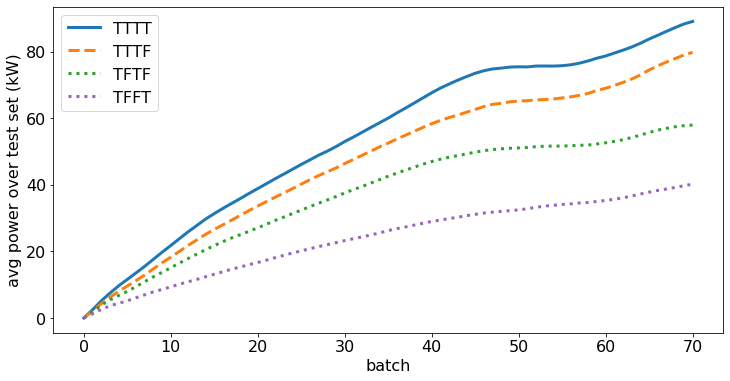

batch: 80/400.


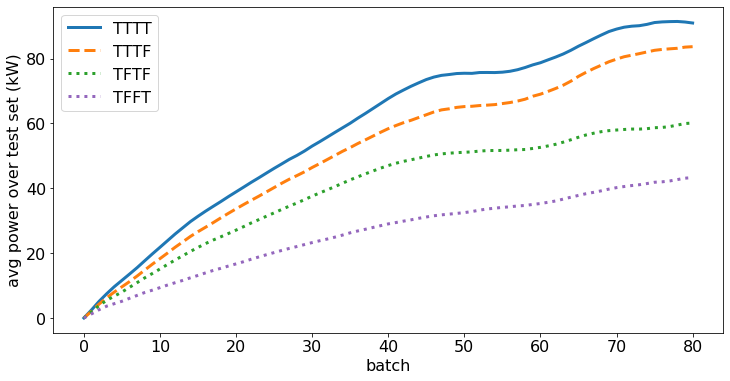

batch: 90/400.


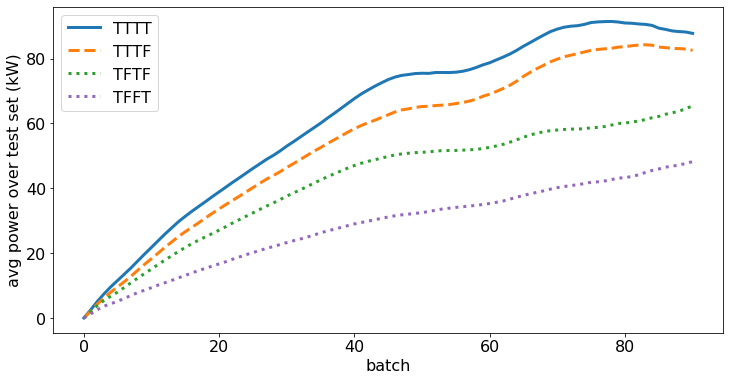

batch: 100/400.


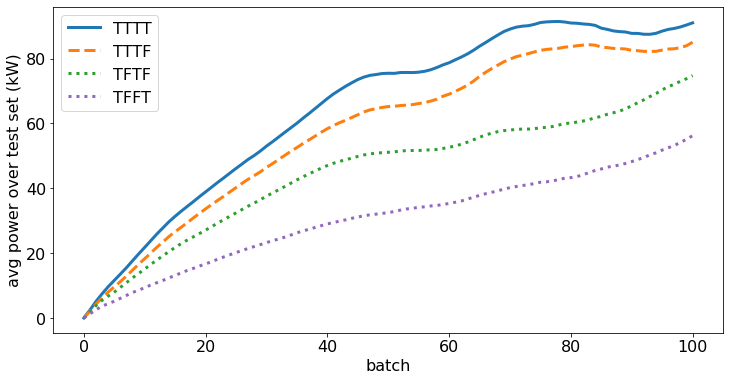

batch: 110/400.


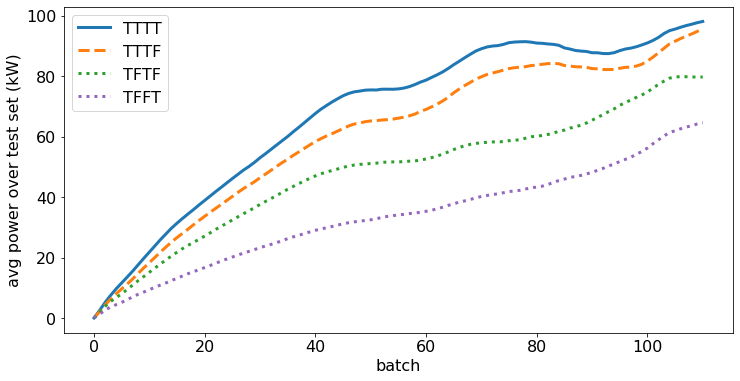

batch: 120/400.


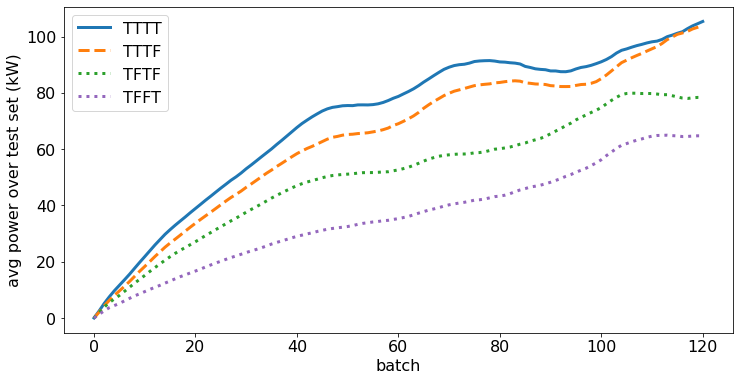

batch: 130/400.


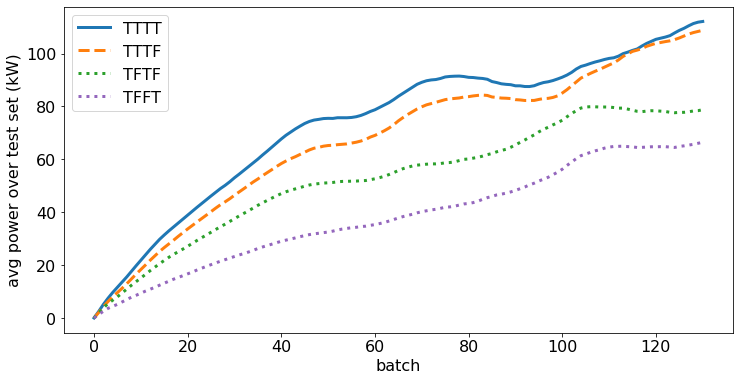

batch: 140/400.


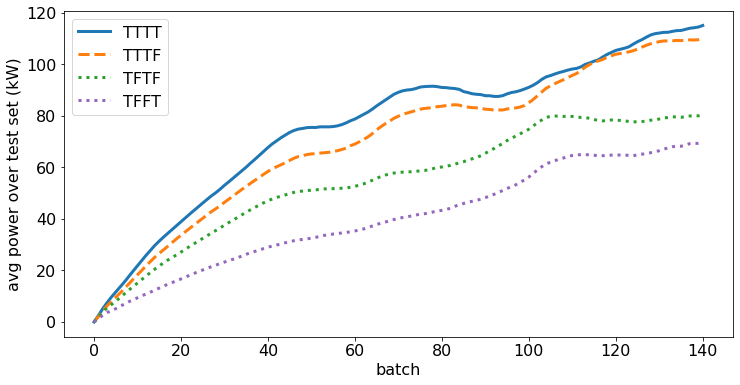

batch: 150/400.


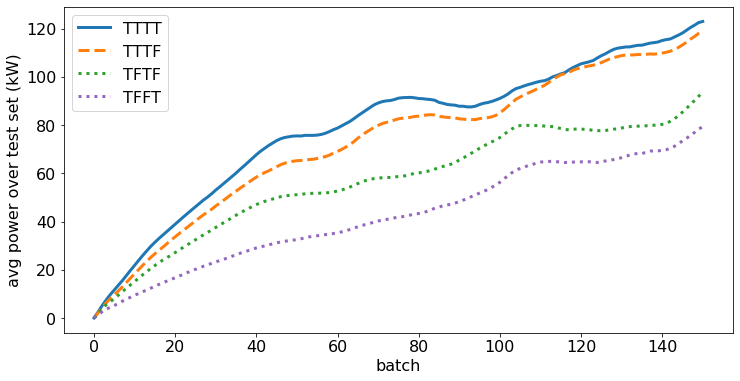

batch: 160/400.


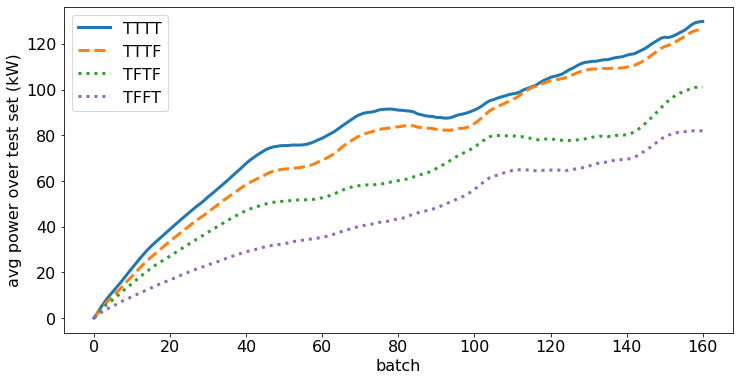

batch: 170/400.


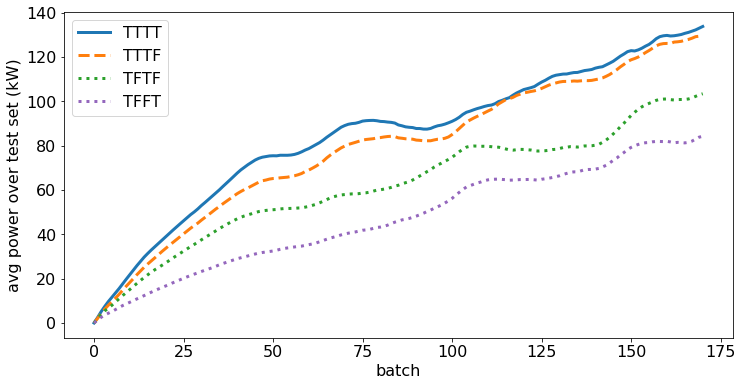

batch: 180/400.


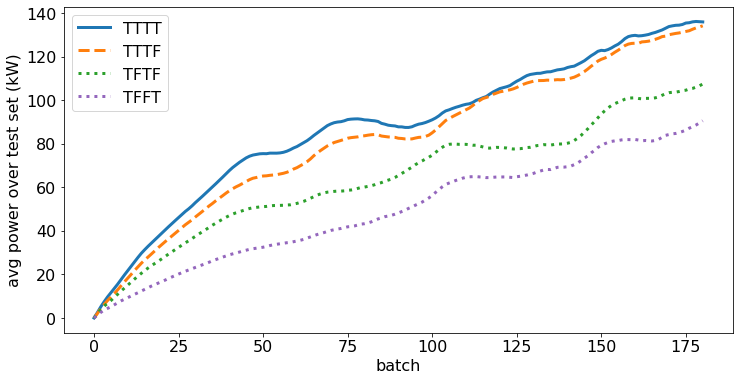

batch: 190/400.


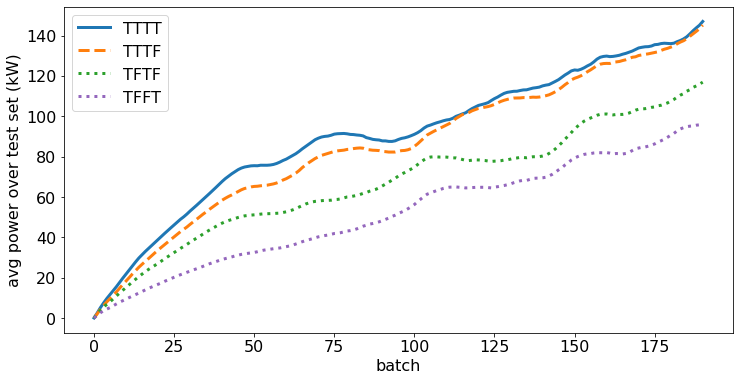

batch: 200/400.


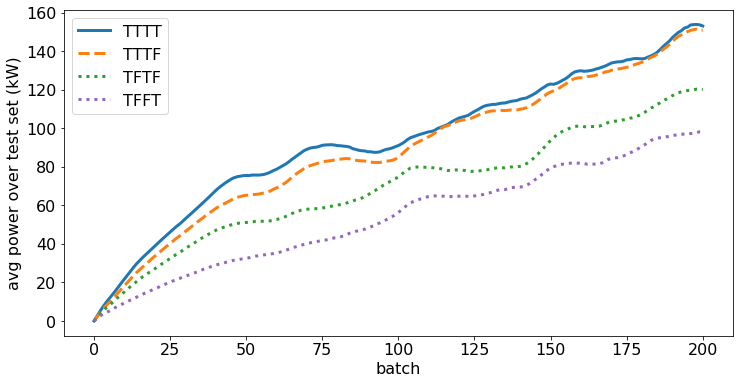

batch: 210/400.


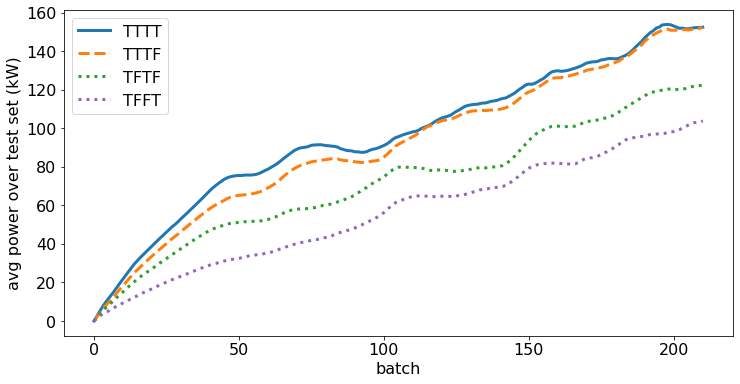

batch: 220/400.


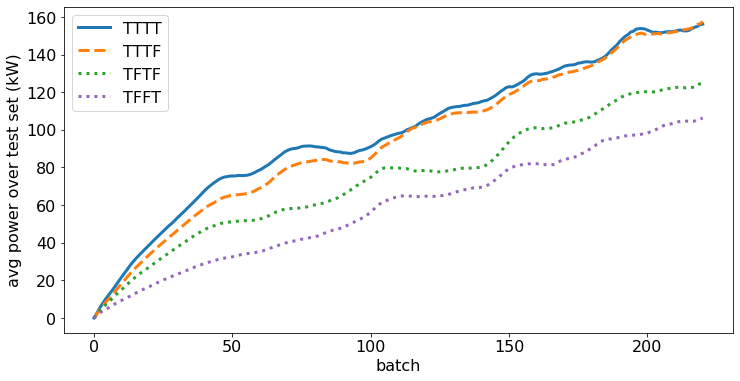

batch: 230/400.


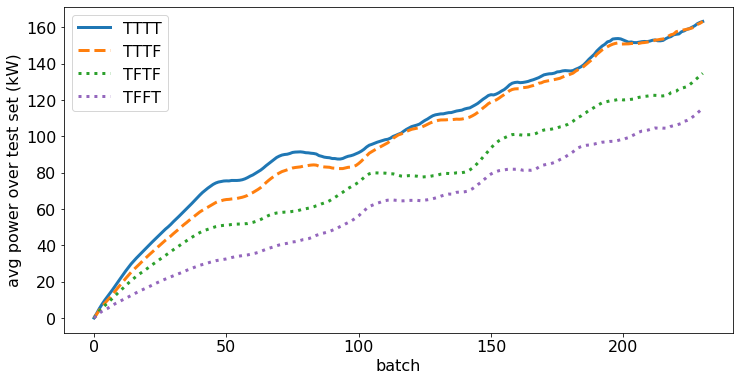

batch: 240/400.


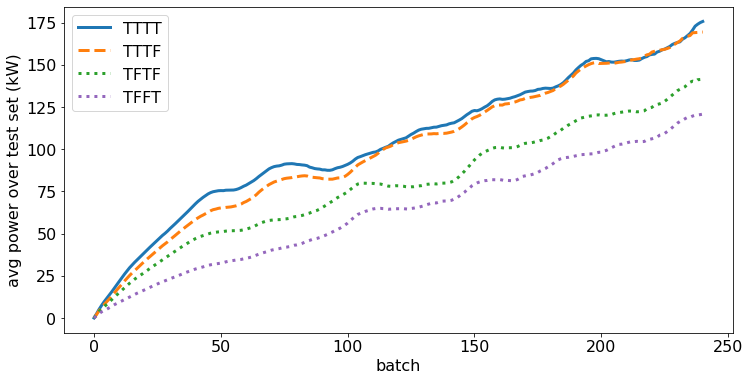

batch: 250/400.


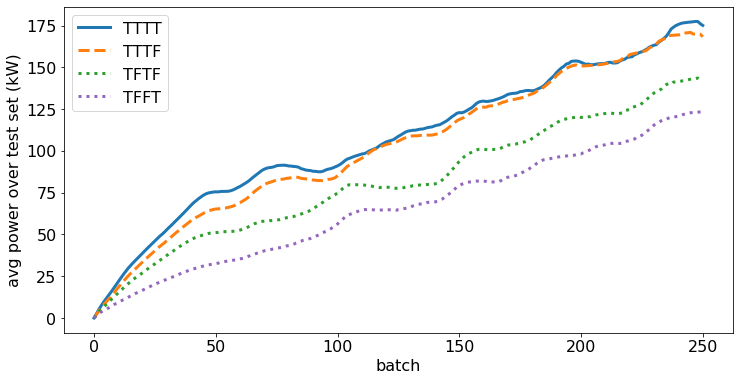

batch: 260/400.


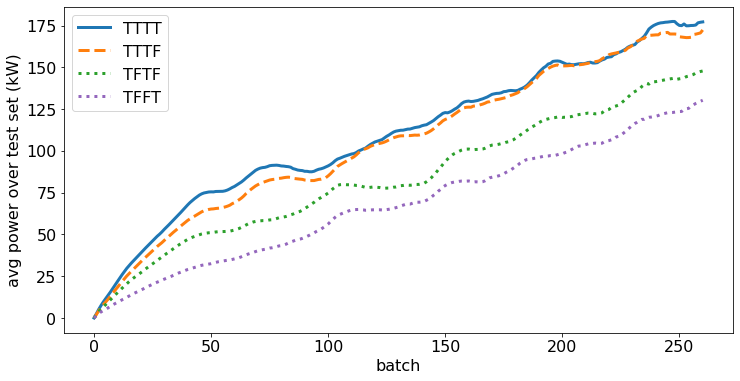

batch: 270/400.


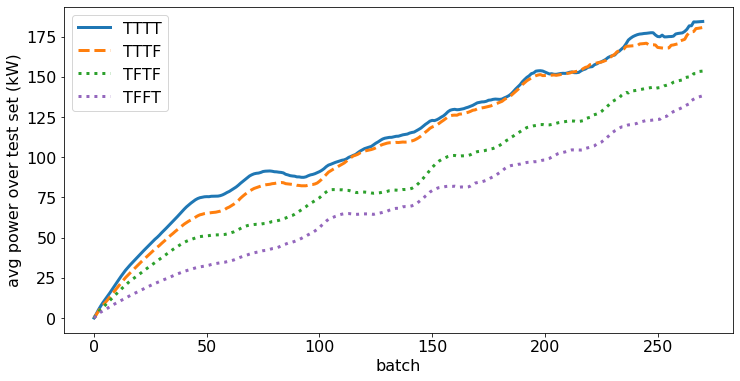

batch: 280/400.


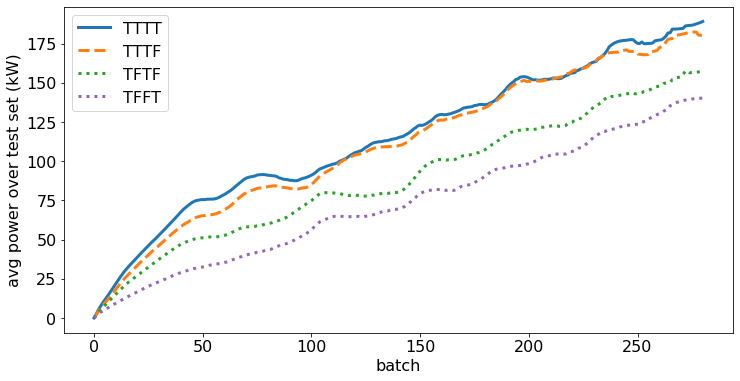

batch: 290/400.


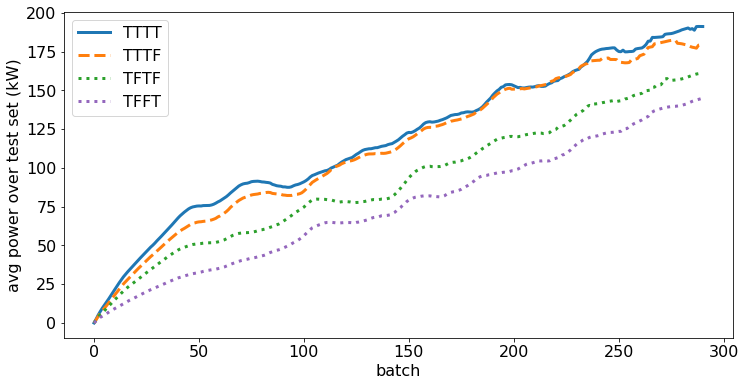

batch: 300/400.


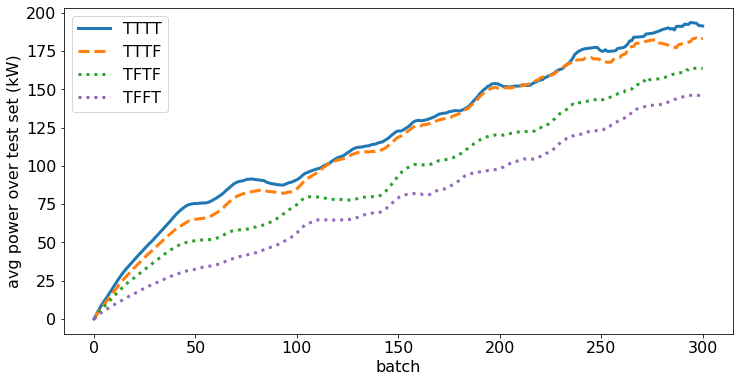

batch: 310/400.


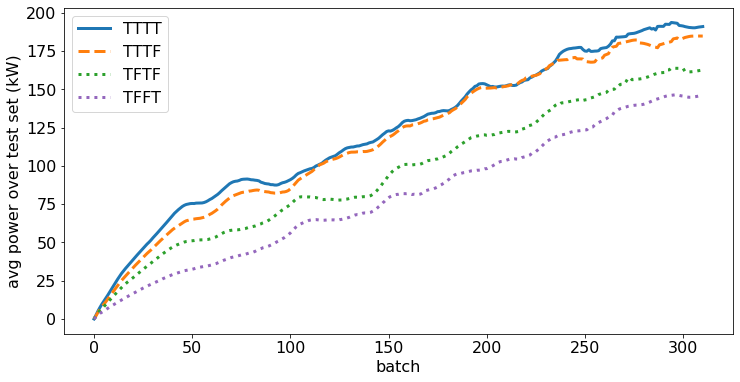

batch: 320/400.


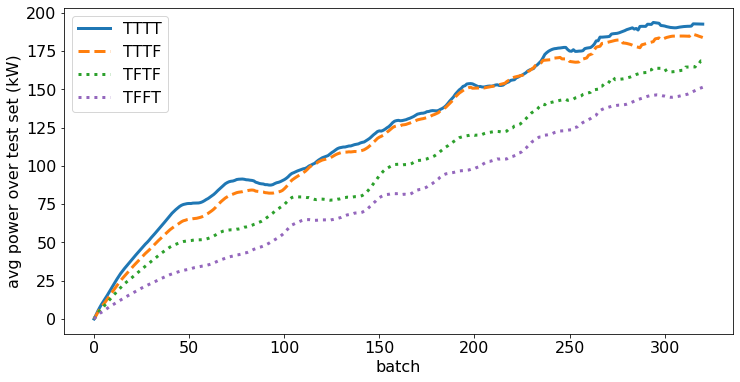

batch: 330/400.


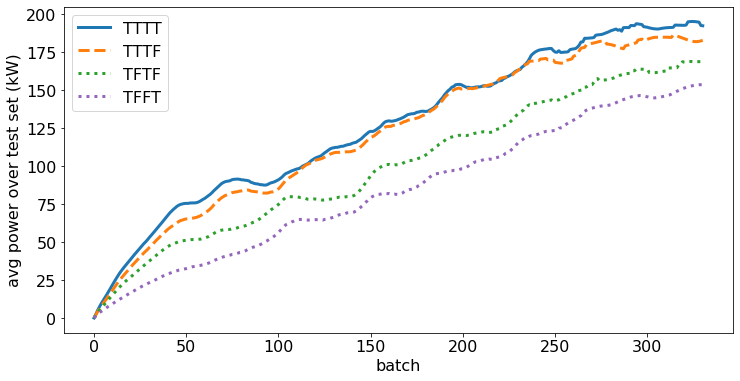

batch: 340/400.


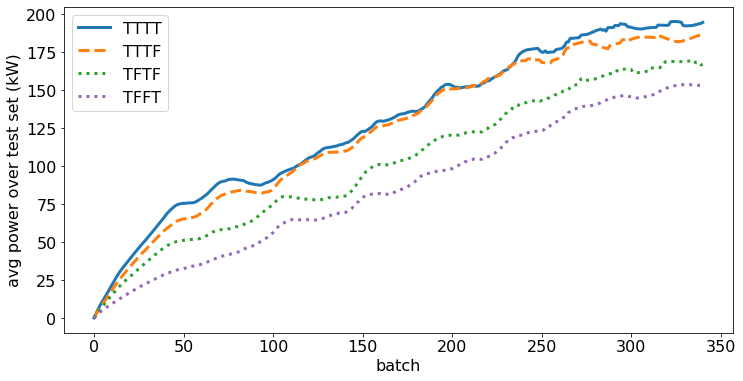

batch: 350/400.


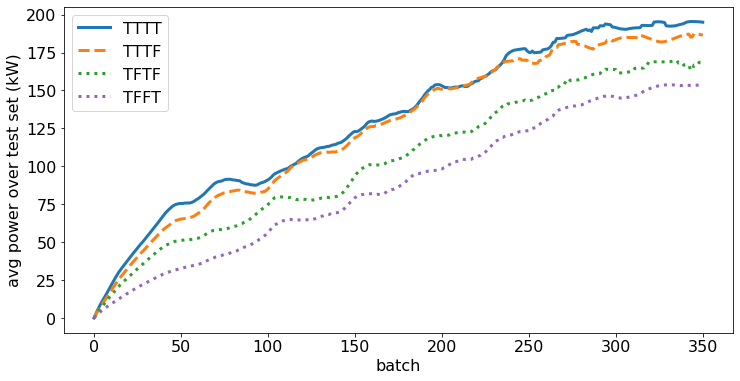

batch: 360/400.


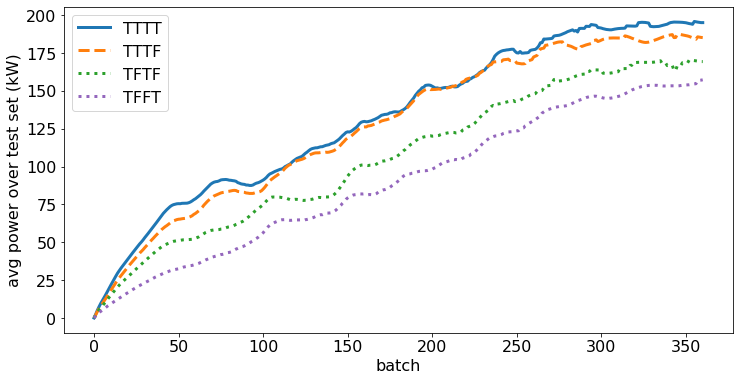

batch: 370/400.


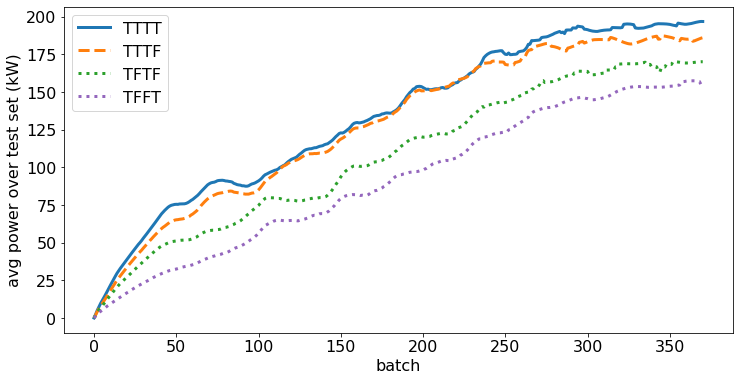

batch: 380/400.


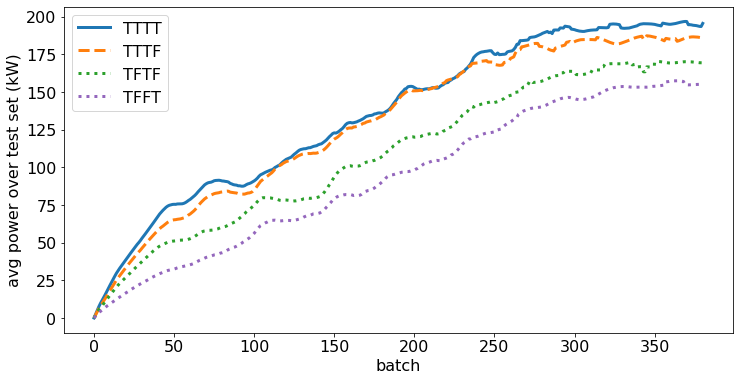

batch: 390/400.


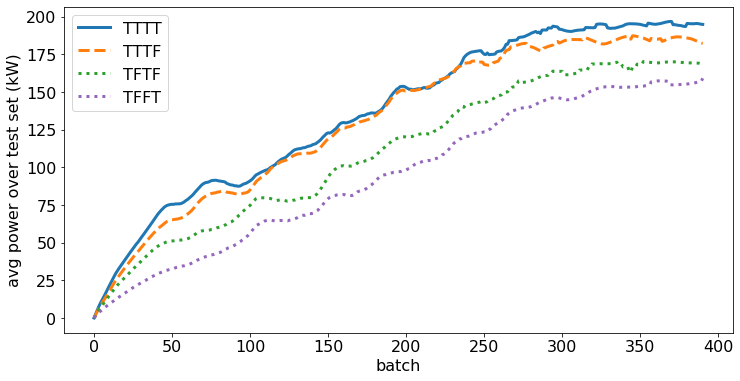

batch: 400/400.


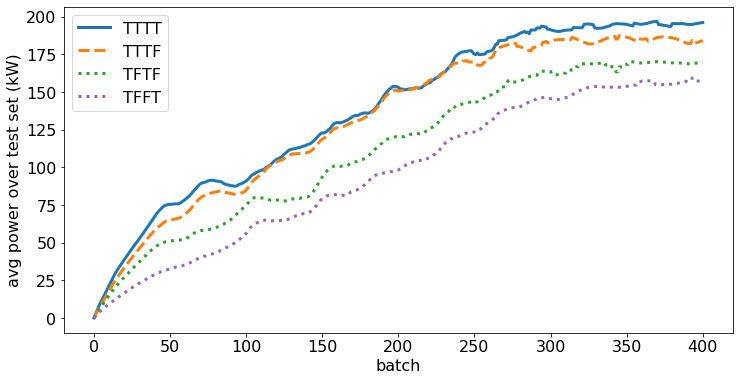

In [106]:
# init DPC model
model = DPCModel(**model_config)

# init training
opt = torch.optim.Adam(model.parameters(), lr=lr)

opt_losses = []
# u_viol_losses = []
# power_losses = []
samples_skipped = 0

# evaluate and save performance of untrained model on test set
# note: test set only used to evaluate performance; not used for training
ws_test = torch.tensor([[4.], [6.], [8.]])
# ws_test = torch.tensor([8.])
# ws_test = torch.tensor([[ws_max]])
wd_test = torch.tensor([wd_fixed])
# wd_test = torch.tensor([[260.], [270.], [359.]])
# wd_test = torch.tensor([[0.], [90.], [180.], [270.]])
# active_turbs_test = [torch.tensor([True, True, True, True])]

# active_turbs_test = [torch.tensor([True, True, True, True]), 
#                      torch.tensor([True, True, True, False]),
#                      torch.tensor([True, False, True, False]),
#                      torch.tensor([True, False, False, True]),
#                      torch.tensor([True, False, False, False])]

active_turbs_test = [torch.tensor([True, True, True, 
                                   True, True, True, 
                                   True, True, True]), 
                     torch.tensor([True, True, True, 
                                   True, True, True, 
                                   True, True, False]),
                     torch.tensor([True, True, True, 
                                   True, True, True, 
                                   True, False, False]),
                     torch.tensor([True, True, True, 
                                   True, True, False, 
                                   True, False, False])]

test_powers = [[] for i in range(len(active_turbs_test))]
test_power(ws_test, wd_test, test_powers,  \
    x_coord, y_coord, z_coord, active_turbs_test=active_turbs_test) # modifies test_powers

# train
for batch in range(num_batches):
            
    opt_loss = 0.
    u_viol_loss = 0.
    power_loss = 0.
    ws_all = []
    wd_all = []
    active_turbs_all = []
    u_all = []
    clipped_u_all = []

    # forward pass
#     for wd in torch.linspace(0, 55, 12):
#     for wd in torch.tensor([[0.], [5.], [10.], [15.], [20.], [25.], [30.], [35.], [40.], [45.], [50.], [55.]]):
#         for rep in range(3):
    for sample in range(batch_size):
        # generate training data at random from desired range
        # for real farm, would use historical ws and wd data instead
        ws = torch.rand(1) * (ws_max - 4.0) + 4.0 # ws from [4, ws_max]
        # ws = (torch.rand(1)*.5+.5) * ws_max 
#         ws = torch.tensor([ws_max])

#         wd = torch.rand(1) * 89. + 270. # vary wd from 270 to 359
#         wd = torch.rand(1) * 359. # vary wd from 0 to 359
#         wd = wd_fixed + .1*(torch.rand(1) -.5) # wd varies around wd_fixed
#         wd = wd_fixed + 5.*torch.rand(1)
        wd = torch.tensor([wd_fixed])

        active_turbs = torch.rand(nturbs) < active_prob
#         active_turbs = torch.tensor([True, True, True, True])
        if torch.all(active_turbs == torch.tensor([False] * nturbs)):
            # if all turbines are dropped out then no need to look for control action
            samples_skipped += 1
            continue

        ws_all.append(ws.detach().numpy())
        wd_all.append(wd.detach().numpy())
        active_turbs_all.append(active_turbs.detach().numpy())

        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
            get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)
        clipped_u_sorted, clipped_u, u = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
        flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
        p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
        power_cost = -torch.sum(p)
        u_all.append(u.detach().numpy())
        clipped_u_all.append((clipped_u).detach().numpy())

        # cost from soft constraints (violating bounds on yaw angle)
#         u_viol_lower = F.relu(umin - u*umax)
#         u_viol_upper = F.relu(u*umax - umax)

#         u_viol_cost = u_penalty * torch.sum(torch.sqrt(u_viol_lower.pow(2) + u_viol_upper.pow(2) + 1e-16))
#         if torch.max(u*umax > umax):
#             print("u > umax", u_viol_upper)
#         if torch.max(u*umax < umin):
#             print("u < umin", torch.sum(u_viol_lower), u_viol_cost)
        # total cost
#         total_cost = u_viol_cost + power_cost
        total_cost = power_cost
    
        # sum over data in batch
        opt_loss += total_cost / torch.sum(active_turbs)
#         u_viol_loss += u_viol_cost
#         power_loss += power_cost

    opt_loss /= batch_size
#     u_viol_loss /= batch_size
#     power_loss /= batch_size

    # backward pass
    opt.zero_grad()
    opt_loss.backward()

    opt.step()

    opt_losses.append(opt_loss.detach().numpy())
#     u_viol_losses.append(u_viol_loss.detach().numpy())
#     power_losses.append(power_loss.detach().numpy())
    
    test_power(ws_test, wd_test, test_powers, \
         x_coord, y_coord, z_coord, active_turbs_test=active_turbs_test) # modifies test_powers
    
    if (batch+1) % 10 == 0:
        print("batch: %d/%d."%(batch+1, num_batches))
#         print("test power: ", test_powers[0][-1])
#         print("")

        plt.rcParams.update({'font.size': 16})
        plt.plot(-np.array(test_powers[0]-test_powers[0][0]), label='TTTT', color='tab:blue', linestyle='-', linewidth=3)
        plt.plot(-np.array(test_powers[1]-test_powers[1][0]), label='TTTF', color='tab:orange', linestyle='--', linewidth=3)
        plt.plot(-np.array(test_powers[2]-test_powers[2][0]), label='TFTF', color='tab:green', linestyle=':', linewidth=3)
        plt.plot(-np.array(test_powers[3]-test_powers[3][0]), label='TFFT', color='tab:purple', linestyle=':', linewidth=3)
#         plt.plot(-np.array(test_powers[4]-test_powers[4][0]), label='TFFF', color='tab:red', linestyle=':', linewidth=3)
#         plt.plot(-np.array(test_powers[5]-test_powers[5][0]), label='TFFF', color='tab:red', linestyle=':', linewidth=3)
#         plt.plot(-np.array(test_powers[6]-test_powers[6][0]), label='TFFF', color='tab:red', linestyle=':', linewidth=3)
        plt.legend()
        plt.xlabel('batch')
        plt.ylabel('avg power over test set (kW)')
        fig = plt.gcf()
        fig.set_size_inches(12,6)
        plt.show()

## FLORIS data

In [184]:
# ws =[3, 4, 5, 6, 7, 8]
# validaton ws=[4, 6, 8]

### 9 turbines ###

yaw_9t = [np.array([20.31, 20.31, 0., 
                       18.75, 18.75, 0., 
                       20.31, 18.75, 0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.   ]),
          np.array([18.75, 20.31, 0.,
                    15.6, 20.31, 0.,
                    18.75, 20.31, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([15.63, 20.31, 0., 
                    15.63, 18.75, 0.,
                    15.63, 18.75, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    7.8125, 6.25, 0.])]

p_FLORIS_9t = np.array([12860.81, 8529.32, 5248.17, 2816.35, 1189.24, 212.07])
p_baseline_9t = np.array([11570.69, 7604.86, 4592.45, 2426.84, 981.51, 188.34])    
p_FLORIS_validation_9t = np.array([12860.81, 5248.17, 1189.24])
                      
### 8 turbines ###
yaw_8t = [np.array([20.31, 20.31, 0.,
                 20.31, 18.75, 0.,
                 18.75, 0.]), 
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0.,
                    18.75, 0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    18.75, 0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    20.31, 0.]),
          np.array([7.81, 6.25, 0., 
                    7.81, 6.25, 0.,
                    20.31, 0.])]
p_FLORIS_8t = np.array([11571.26, 7687.48, 4740.22, 2548.53, 1081.40, 195.62])
p_baseline_8t = np.array([10468.81, 6888.82, 4164.31, 2204.15, 893.72, 161.56])
p_FLORIS_validation_8t = np.array([11571.26, 4740.22, 1081.40])

    
### 7 turbines ###
yaw_7t = [np.array([20.31, 20.31, 0., 
                    20.31, 18.75, 0., 
                    0.]),
          np.array([15.63, 18.75, 0.,
                    15.63, 18.75, 0., 
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 20.31, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    15.63, 18.75, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    7.81, 6.25, 0.,
                    0.])] 
p_FLORIS_7t = np.array([10267.05, 6818.95, 4208.14, 2261.84, 961.89, 177.42])
p_baseline_7t = np.array([9405.13, 6201.89, 3762.19, 2001.59, 822.94, 161.56])
p_FLORIS_validation_7t = np.array([10267.05, 4208.14, 961.89])

### 6 turbines ###
yaw_6t = [np.array([20.31, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 18.75, 0.,
                    18.75, 0.,
                    0.]),
          np.array([18.75, 20.31, 0.,
                    18.75, 0.,
                    0.]),
          np.array([15.63, 21.88, 0.,
                    20.31, 0.,
                    0.]),
          np.array([15.63, 20.31, 0.,
                    20.31, 0.,
                    0.]),
          np.array([7.81, 6.25, 0.,
                    20.31, 0.,
                    0.])]
p_FLORIS_6t = np.array([8978.01, 5977.10, 3689.03, 1994.01, 854.04, 160.97])
p_baseline_6t = np.array([8303.25, 5485.85, 3334.04, 1778.90, 735.15, 134.79])
p_FLORIS_validation_6t = np.array([8978.01, 3689.03, 854.04])

## Training plot

In [108]:
plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({'font.size': 20})
plt.rc('lines', linewidth=3.0)

linestyles = ['-', '--', ':', '-.']

markerstyles = ['+', 'x', '*', 'o']
marker_names = ["DPC", "Opt.", "Lookup", "Baseline"]

plt.rcParams.update({'lines.markersize': 15})

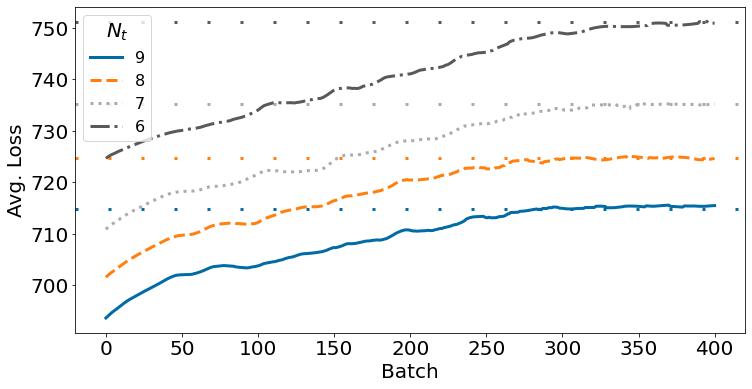

In [109]:
ps_FLORIS_validation = [p_FLORIS_validation_9t, p_FLORIS_validation_8t, \
                        p_FLORIS_validation_7t, p_FLORIS_validation_6t]

for i in range(4):
    nturbs_active = 9-i
    plt.plot(-np.array(np.array(test_powers[i])/nturbs_active), label=str(nturbs_active), 
             color=colors[i], linestyle=linestyles[i], linewidth=3)
    plt.axhline(np.mean(ps_FLORIS_validation[i])/nturbs_active, color=colors[i], linestyle=(0, (1, 10)), linewidth=3)
    
plt.legend(title="$N_t$", prop={'size': 16})
plt.xlabel('Batch')
plt.ylabel('Avg. Loss')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/training.png', 
            bbox_inches='tight')
plt.show()

# Loss averaged over the wind speeds in the validation set
# for each turbine status vector in the validation set, 
# labeled by the number of active turbines (6, 7, 8, or 9.)

## Testing plots

In [113]:
ps_DPC = []

for active_turbs in active_turbs_test:
    ps_t = []
    for ws in torch.tensor([[8], [7], [6], [5], [4]]):
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
            get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)

        clipped_u_sorted, clipped_u, u = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)

        flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
        p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
        ps_t.append(torch.sum(p).detach().numpy().flatten()[0])
    ps_DPC.append(np.array(ps_t))
ps_DPC.reverse()

In [116]:
p_FLORIS_6t[:-1]

array([8978.01, 5977.1 , 3689.03, 1994.01,  854.04])

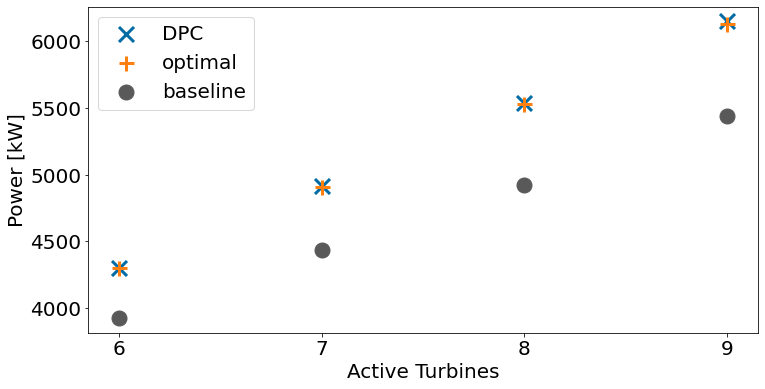

In [121]:
ps_FLORIS = [p_FLORIS_6t[:-1], p_FLORIS_7t[:-1], p_FLORIS_8t[:-1], p_FLORIS_9t[:-1]]
ps_baseline = [p_baseline_6t[:-1], p_baseline_7t[:-1], p_baseline_8t[:-1], p_baseline_9t[:-1]]

nturbs_active = [6, 7, 8, 9]
plt.scatter(nturbs_active, [np.mean(p) for p in ps_DPC], color=colors[0], \
            marker='x', label="DPC")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_FLORIS], color=colors[1], \
            marker='+', label="optimal")
plt.scatter(nturbs_active, [np.mean(p) for p in ps_baseline], \
            marker='o', color=colors[3], label="baseline")
plt.xlabel("Active Turbines")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
ax=plt.gca()
plt.xticks(ticks=nturbs_active, labels=[str(nt) for nt in nturbs_active])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/testing_Nt.png', 
            bbox_inches='tight')
plt.show()

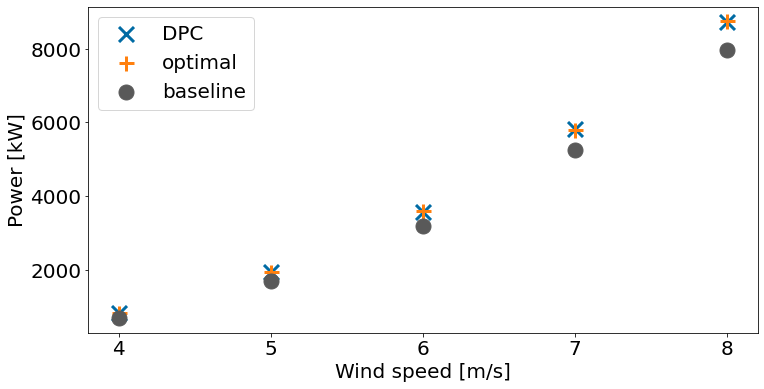

In [144]:
ws_plot =[4, 5, 6, 7, 8]
def t_to_ws(ps_t):
    ps_ws = np.zeros(len(ws_plot))
    for ps in ps_t:
        for i in range(len(ps)):
            ps_ws[i] += ps[i]
    ps_ws /= len(ws_plot)
    return np.flip(ps_ws)

ps_DPC_ws = t_to_ws(ps_DPC)
ps_FLORIS_ws = t_to_ws(ps_FLORIS)
ps_baseline_ws = t_to_ws(ps_baseline)


plt.scatter(ws_plot, ps_DPC_ws, color=colors[0], marker='x', label="DPC")
plt.scatter(ws_plot, ps_FLORIS_ws, color=colors[1], marker='+', label="optimal")
plt.scatter(ws_plot, ps_baseline_ws, marker='o', color=colors[3], label="baseline")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power [kW]")
# plt.semilogy()
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/testing_u.png', 
            bbox_inches='tight')
plt.show()

## yaw plot

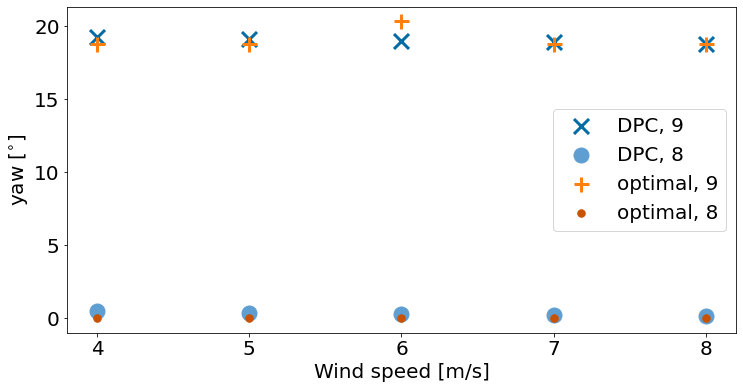

In [145]:
ws_plot =[4, 5, 6, 7, 8]
t1_9t_FLORIS = [yaw_9t_ws[7] for yaw_9t_ws in yaw_9t]
t1_8t_FLORIS = [yaw_8t_ws[7] for yaw_8t_ws in yaw_8t]
t1_9t_FLORIS.reverse()
t1_8t_FLORIS.reverse()

t1_9t_DPC = []
active_turbs = active_turbs_test[0]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)

    _, clipped_u, _ = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
    t1_9t_DPC.append(clipped_u[7].detach().numpy())

t1_8t_DPC = []
active_turbs = active_turbs_test[1]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)

    _, clipped_u, _ = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
    t1_8t_DPC.append(clipped_u[7].detach().numpy())
    
plt.scatter(ws_plot, t1_9t_DPC, color=colors[0], marker='x', label="DPC, 9")
plt.scatter(ws_plot, t1_8t_DPC, color=colors[4], marker='o', label="DPC, 8")
plt.scatter(ws_plot, t1_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t1_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/yaw_t1.png', 
            bbox_inches='tight')
plt.show()

In [165]:
np.append(np.array(t1_9t_DPC) - np.array(t1_9t_FLORIS[1:]), 
                  np.array(t1_8t_DPC) - np.array(t1_8t_FLORIS[1:]))

array([ 0.5124054 ,  0.37139893, -1.31761986,  0.13163757, -0.00841141,
        0.44929314,  0.37178993,  0.29680634,  0.22395515,  0.15369606])

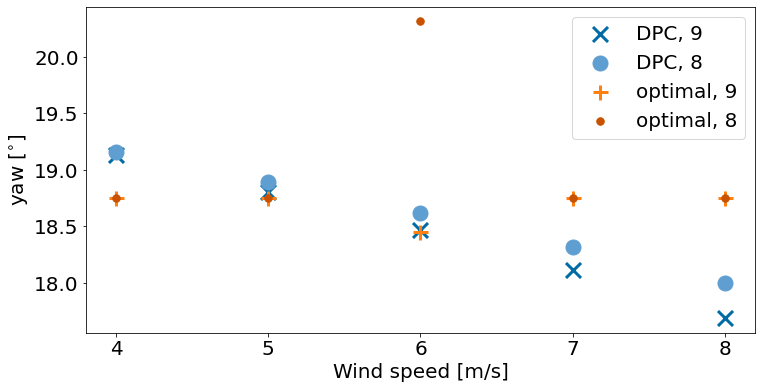

In [179]:
ws_plot =[4, 5, 6, 7, 8]
t2_9t_FLORIS = [yaw_9t_ws[4] for yaw_9t_ws in yaw_9t]
t2_8t_FLORIS = [yaw_8t_ws[4] for yaw_8t_ws in yaw_8t]
t2_9t_FLORIS.reverse()
t2_8t_FLORIS.reverse()

t2_9t_DPC = []
active_turbs = active_turbs_test[0]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)

    _, clipped_u, _ = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
    t2_9t_DPC.append(clipped_u[4].detach().numpy())

t2_8t_DPC = []
active_turbs = active_turbs_test[1]
for ws in torch.tensor([[4], [5], [6], [7], [8]]):
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)

    _, clipped_u, _ = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
    t2_8t_DPC.append(clipped_u[4].detach().numpy())
    
plt.scatter(ws_plot, t2_9t_DPC, color=colors[0], marker='x', label="DPC, 9")
plt.scatter(ws_plot, t2_8t_DPC, color=colors[4], marker='o', label="DPC, 8")
plt.scatter(ws_plot, t2_9t_FLORIS[1:], color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_plot, t2_8t_FLORIS[1:], color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_plot, labels=[str(ws) for ws in ws_plot])
plt.savefig('/Users/jani/Documents/research/windFarmControl/2023ACC/figures/yaw_t2.png', 
            bbox_inches='tight')
plt.show()

In [180]:
t2_9t_DPC[2]

array(18.46593, dtype=float32)

In [181]:
np.append(np.array(t2_9t_DPC) - np.array(t2_9t_FLORIS[1:]), 
                  np.array(t2_8t_DPC) - np.array(t2_8t_FLORIS[1:]))

array([ 0.3782711 ,  0.05768776,  0.01593094, -0.63739967, -1.05879211,
        0.40301323,  0.14197922, -1.6902433 , -0.42851639, -0.75075722])

In [195]:
wd = torch.tensor([wd_fixed])
ws = torch.tensor([6.])
active_turbs = torch.tensor([True, True, True,
                             True, True, True,
                             True, True, True])

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
    get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)    

clipped_u = torch.tensor(yaw_9t[2])
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
p1 = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p1).detach().numpy(), 1))
print("")

yaw_9t_alt = yaw_9t[2].copy()
yaw_9t_alt[4]=18.45
clipped_u = torch.tensor(yaw_9t_alt)
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
p2 = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p2).detach().numpy(), 1))
print("")

yaw_9t_alt0 = yaw_9t[2].copy()
yaw_9t_alt0[4]=0.
clipped_u = torch.tensor(yaw_9t_alt0)
clipped_u_sorted = clipped_u[inds_sorted.flatten()]
print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)
p3 = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p3).detach().numpy(), 1))
print("")

clipped u:  [18.75 20.31  0.   15.6  20.31  0.   18.75 20.31  0.  ]
power:  5248.3

clipped u:  [18.75 20.31  0.   15.6  18.45  0.   18.75 20.31  0.  ]
power:  5247.8

clipped u:  [18.75 20.31  0.   15.6   0.    0.   18.75 20.31  0.  ]
power:  5172.1



In [193]:
(torch.sum(p1) - torch.sum(p2))/torch.sum(p1)*100

tensor(0.0085, dtype=torch.float64)

In [196]:
(torch.sum(p1) - torch.sum(p3))/torch.sum(p1)*100

tensor(1.4520, dtype=torch.float64)

## test one case

In [741]:
wd = torch.tensor([wd_fixed])
active_turbs = torch.tensor([True, True, True,
                             True, False, True,
                             True, True, False])

for ws in torch.tensor([4., 6., 8]):
    ws = torch.tensor([ws])

    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active = \
        get_turbine_mesh(wd, x_coord, y_coord, z_coord, active_turbs=active_turbs)    
    
    clipped_u_sorted, clipped_u, u = get_control(ws, wd, inds_sorted, active_turbs=active_turbs)
    print("clipped u: ", np.round(clipped_u.detach().numpy(), 2))

    flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, x_coord_active)

    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    print("power: ", np.round(p.detach().numpy().flatten(), 1))
    print("net power: ", np.round(torch.sum(p).detach().numpy(), 1))
    print("")

clipped u:  [19.66 19.04  0.    6.66  0.   17.77  1.66]
power:  [146.2 166.  150.3 121.8 136.9 134.  151.3]
net power:  1006.6

clipped u:  [19.45 18.41  0.    6.13  0.   17.65  1.07]
power:  [625.5 693.1 638.8 543.  592.6 586.1 652.6]
net power:  4331.8

clipped u:  [19.12 17.65  0.    5.55  0.   17.34  0.57]
power:  [1524.3 1677.3 1554.1 1343.8 1439.8 1418.7 1590.1]
net power:  10548.1

